In [1]:
LANGUAGE = 'tsn'
EXPERIMENT = 'final_gpt_active_learning'
PREFERRED_GPU = 'cuda:5' # 'cuda:0'

In [2]:
# Prevent WandB from printing summary in cell output
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [3]:
import os
import sys
import yaml
import copy
import yaml
import json
import wandb
import torch
import datetime
import warnings
import itertools

import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
from datasets import load_dataset
from sklearn.exceptions import UndefinedMetricWarning
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from openai import APIStatusError, RateLimitError, APIConnectionError
from sklearn.metrics import f1_score
import numpy as np

from openai import OpenAI
from getpass import getpass

torch.cuda.empty_cache()
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [4]:
# Add src module to system path
src_module_path = os.path.abspath('../../../')
if src_module_path not in sys.path:
    sys.path.append(src_module_path)

# Import functions and classes from custom modules
from src.data.preprocess import (
    align_labels_for_many_records,
    TorchDataset,
    balanced_split_for_active_learning
)

from src.query.query_gpt import add_annotation_examples_for_batch, add_annotation_examples
from src.query.prompts import MAIN_PROMPT_FOR_BATCH, MAIN_PROMPT

from src.utils.utils import (predict_sequence_max_uncertainty,
                             batch_indices_to_global_indices,
                             print_classification_report,
                             calculate_micro_f1_for_batches,
                             calculate_macro_f1_for_batches)

from src.models.xlmr_ner import XLMRobertaForNER

In [5]:
# Init openai client
openai_client = OpenAI(api_key=getpass("OPENAI API key:"))

# Weights and Biases login
wandb.login(key=getpass("Weights and Biases API key:"))

True

In [6]:
# Specifying path to the necessary files and folders
PATH_TO_SRC = os.path.abspath('../../../')

CONFIG_PATH = os.path.join(PATH_TO_SRC, "settings/config.yml")

BATCH_ANNOTATION_EXAMPLES_PATH = os.path.join(
    PATH_TO_SRC, 'src/query/ner_examples_all_languages_for_batch.json'
)

SINGLE_ANNOTATION_EXAMPLES_PATH = os.path.join(
    PATH_TO_SRC, 'src/query/ner_examples_all_languages.json'
)

In [7]:
# Reading config file
config = yaml.safe_load(open(CONFIG_PATH))

# Printing out name of the current language
language_name = config['languages_names'][LANGUAGE]
language_name

'Tswana'

In [8]:
batch_examples = add_annotation_examples_for_batch(BATCH_ANNOTATION_EXAMPLES_PATH, language_name)
single_examples = add_annotation_examples(SINGLE_ANNOTATION_EXAMPLES_PATH, language_name)

In [9]:
label_mapping = config['label_mapping']

label_to_index = {value: key for key, value in label_mapping.items()}

# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Initialize model
base_model = XLMRobertaForNER(model_name=config['model_name'], 
                         num_labels=len(config['label_mapping'].keys()))

# Choose a GPU to use
default_device = config['gpu_settings']['default_device'] if \
    PREFERRED_GPU=='' else PREFERRED_GPU

# Send model to GPU if cuda is available otherwise use CPU
device = torch.device(default_device if torch.cuda.is_available() else "cpu")
print(device)

base_model.to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-mini and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:5


XLMRobertaForNER(
  (xlmr): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 384, padding_idx=1)
      (position_embeddings): Embedding(514, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
          

In [10]:
ask_gpt_params = {
    'language': language_name,
    #'examples': add_annotation_examples_for_batch(ANNOTATION_EXAMPLES_PATH, language_name),
    'openai_client': openai_client,
    #'user_prompt': MAIN_PROMPT_FOR_BATCH,
    'model': 'gpt-4-0125-preview',
    'temperature': config['foundation_model']['temperature']
}

In [11]:
def ask_gpt_short(user_prompt, language, openai_client, temperature, model,
                  system_prompt=None, max_tokens=1000):

    if system_prompt is None:
        system_prompt = f"You are a named entity labelling expert in {language} language."

    # Save query params
    query_params = {
        'model': model,
        'temperature': temperature,
        'messages': [{"role": "system", "content": system_prompt},
                     {"role": "user", "content": user_prompt}],
        'max_tokens': max_tokens,
    }

    if model == 'gpt-4-1106-preview' or model == 'gpt-4-0125-preview':
        query_params['response_format'] = {"type": "json_object"}

    try:
        # Query the model
        response = openai_client.chat.completions.create(**query_params)
        # Extract model answer
        answer = response.choices[0].message.content
        return answer

    except APIConnectionError as e:
        raise Exception(f"The server could not be reached: {e.__cause__}")
    except RateLimitError as e:
        raise Exception(f"A 429 status code was received: {e}")
    except APIStatusError as e:
        raise Exception(f"Non-200-range status code received: {e.status_code}, {e.response}")

In [12]:
def update_ner_annotations_with_gpt(dataset, batch_examples, single_examples):
    """Updates a dataset with Named Entity Recognition (NER) annotations 
    using predictions from a GPT model."""
    print("Asking GPT to annotate data...")
    indices_to_keep = []
    predicted_ner_tags = []
    true_ner_tags = []

    original_dataset_len = len(dataset)

    for i in range(0, original_dataset_len, 2):
        if i+1 < original_dataset_len:  # Batch of 2
            print(f'\nSample {i+1} and {i+2}:')

            record_0 = dataset[i]
            record_1 = dataset[i+1]

            # 1) Query model
            try:
                # Extract tokens from current record
                tokens = {'record_0': record_0['tokens'], 'record_1': record_1['tokens']}

                batch_user_prompt = MAIN_PROMPT_FOR_BATCH.format(
                    language=language_name,
                    inputs=str(tokens),
                    examples=batch_examples
                )

                # Query the model
                new_labels_gpt = ask_gpt_short(user_prompt=batch_user_prompt, **ask_gpt_params)
                outputs = json.loads(new_labels_gpt)['output']

            except Exception as e:  # If output from the model cannot be extracted
                print(f'Skipping indexes {i} and {i+1}, cannot extract output from the model. Error:')
                print(e, '\n')
                continue

            # Try to extract labels for the first record
            try:
                ner_tags_0 = [t[1] if len(t) > 1 and t[1] is not None else 'O' for t in outputs['record_0']]
                # If number of tokens == number of labels --> save result
                if len(record_0['true_ner_tags']) == len(ner_tags_0):
                    # Replace out-of-scope labels (e.g, 'B-EVENT')
                    ner_tags_0 = [label_to_index.get(t, 0) for t in ner_tags_0]

                    predicted_ner_tags.append(ner_tags_0)
                    true_ner_tags.append(record_0['true_ner_tags'])
                    indices_to_keep.append(i)
                else:
                    print(f'{i} --> different number of tokens and labels.')
            except Exception as e:
                print(f'{i} --> cannot extract NER labels. Error:')
                print(e, '\n')
                continue

            # Try to extract labels for the second record
            try:
                ner_tags_1 = [t[1] if len(t) > 1 and t[1] is not None else 'O' for t in outputs['record_1']]
                # If number of tokens == number of labels --> save result
                if len(record_1['true_ner_tags']) == len(ner_tags_1):
                    # Replace out-of-scope labels (e.g, 'B-EVENT')
                    ner_tags_1 = [label_to_index.get(t, 0) for t in ner_tags_1]

                    predicted_ner_tags.append(ner_tags_1)
                    true_ner_tags.append(record_1['true_ner_tags'])
                    indices_to_keep.append(i+1)
                else:
                    print(f'{i+1} --> different number of tokens and labels.')
            except Exception as e:
                print(f'{i+1} --> cannot extract NER labels. Error:')
                print(e, '\n')
                continue

        else:
            print(f'\nLast sample {i+1}:')

            record = dataset[i]

            # 1) Query model
            try:
                # Extract tokens from current record
                tokens = record['tokens']

                single_user_prompt = MAIN_PROMPT.format(
                    language=language_name,
                    sentence=str(tokens),
                    examples=single_examples
                )

                new_labels_gpt = ask_gpt_short(user_prompt=single_user_prompt, **ask_gpt_params)
                outputs = json.loads(new_labels_gpt)['output']

            except Exception as e:  # If output from the model cannot be extracted
                print(f'{i} --> cannot extract output from the model. Error:')
                print(e, '\n')
                continue

            # Try to extract labels for the first record
            try:
                ner_tags = [t[1] if len(t) > 1 and t[1] is not None else 'O' for t in outputs]
                # If number of tokens == number of labels --> save result
                if len(record['true_ner_tags']) == len(ner_tags):
                    # Replace out-of-scope labels (e.g, 'B-EVENT')
                    ner_tags = [label_to_index.get(t, 0) for t in ner_tags]
                    predicted_ner_tags.append(ner_tags)
                    true_ner_tags.append(record['true_ner_tags'])
                    indices_to_keep.append(i)
                else:
                    print(f'{i} --> different number of tokens and labels.')
            except Exception as e:
                print(f'{i} --> cannot extract NER labels. Error:')
                print(e, '\n')
                continue

    filtered_dataset = dataset.select(indices_to_keep)

    def update_dataset_with_gpt_annotations(example, index):
        example['ner_tags'] = predicted_ner_tags[index]
        return example

    updated_dataset = filtered_dataset.map(update_dataset_with_gpt_annotations, with_indices=True)

    updated_dataset = updated_dataset.map(
        align_labels_for_many_records,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )

    # Calculate number of annotated and skipped records
    num_annotated_records = len(updated_dataset)
    print(f'{num_annotated_records} records were successfully annotated.')
    if num_annotated_records < original_dataset_len:
        print(f'{original_dataset_len - num_annotated_records} records were skipped.')

    true_ner_tags_flat = list(itertools.chain.from_iterable(true_ner_tags))
    predicted_ner_tags_flat = list(itertools.chain.from_iterable(predicted_ner_tags))
    
    # Calculate F1 score
    f1_score_micro = f1_score(true_ner_tags_flat, predicted_ner_tags_flat, average='micro')
    print(f'F1 micro: {round(f1_score_micro, 2)}')

    return updated_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

Original dataset:
 DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3489
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 499
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 996
    })
})


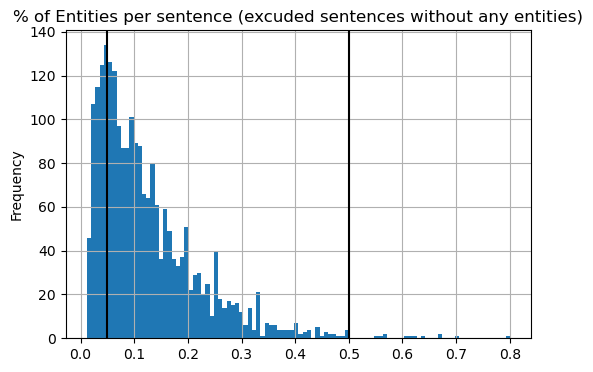

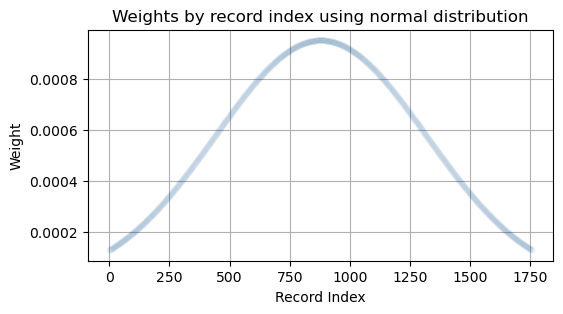

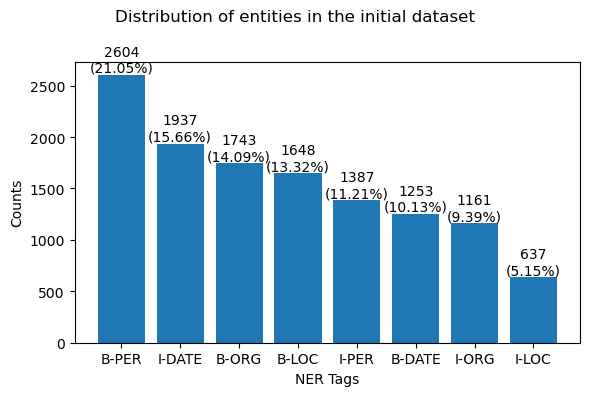

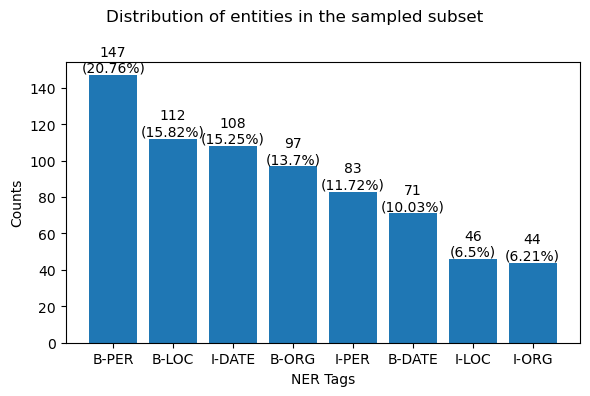

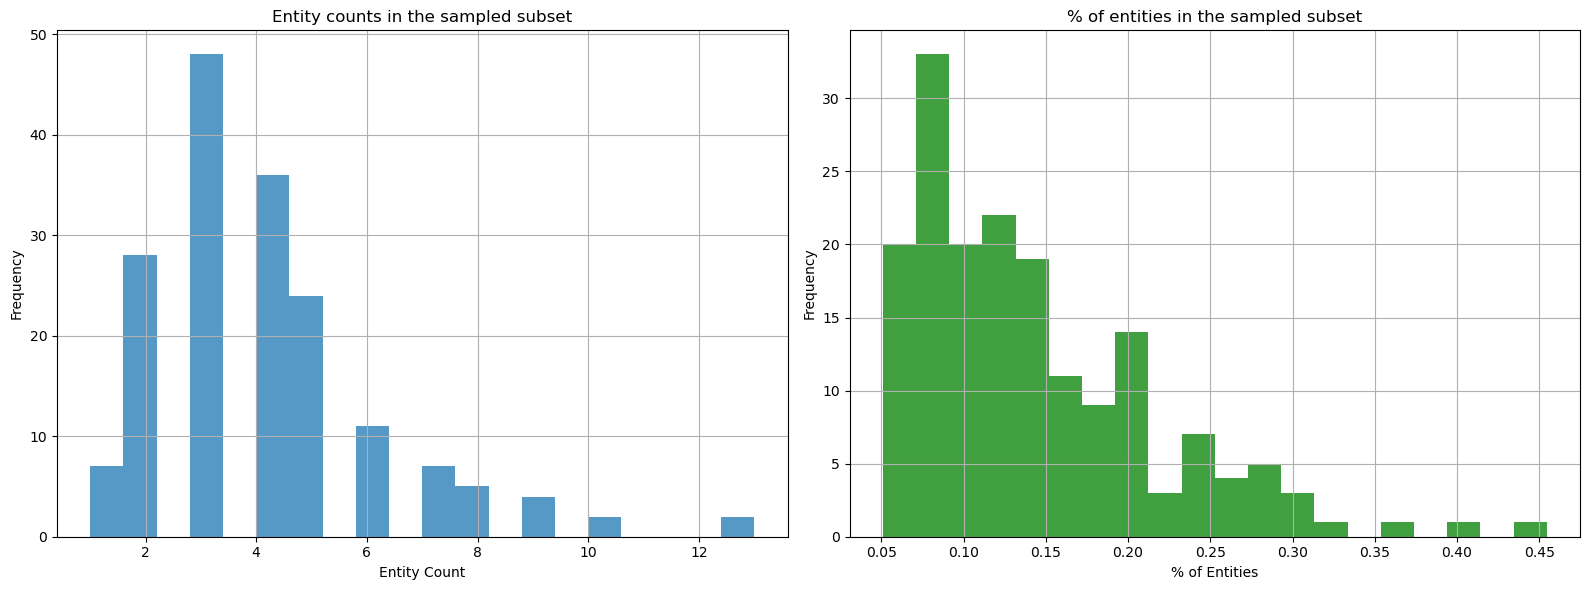

Filter:   0%|          | 0/3489 [00:00<?, ? examples/s]

Split the dataset into initial training (first 5.0%) and active learning (remaining 95.0%).
Overall training dataset size: 3489
Initial training dataset size: 174
Active learning dataset size: 3315


In [13]:
# Download dataset for the specific language 
data = load_dataset(config['dataset'], LANGUAGE)
print("Original dataset:\n", data)

# splitting the data for active learning integration
data = balanced_split_for_active_learning(
    data,
    label_mapping,
    train_key='train',
    split_ratio=config['train_settings']['initial_train_size'],
    verbose=True
)

In [14]:
data = data.map(
    align_labels_for_many_records,
    batched=True,
    fn_kwargs={'tokenizer': tokenizer}
)

Map:   0%|          | 0/3315 [00:00<?, ? examples/s]

In [15]:
# Settings
max_len = config['languages_max_tokens'][LANGUAGE]
print(f'Maximum token length for language {LANGUAGE} is {max_len}')
padding_val = config['tokenizer_settings']['padding_value']

# Convert the datasets.Dataset to a PyTorch Dataset
dataset_init = TorchDataset(data['initial_training'], max_length=max_len, padding_value=padding_val)
dataset_unlabeled = TorchDataset(data['active_learning'], max_length=max_len, padding_value=padding_val)
dataset_test = TorchDataset(data['test'], max_length=max_len, padding_value=padding_val)
dataset_val = TorchDataset(data['validation'],max_length=max_len, padding_value=padding_val)

Maximum token length for language tsn is 137


In [16]:
# Settings
batch_size = config['train_settings']['batch_size']
shuffle = config['train_settings']['shuffle']

# Create PyTorch DataLoaders
dataloader_init = DataLoader(dataset_init,
                             batch_size=batch_size,
                             shuffle=shuffle) # Shuffle only training set
dataloader_unlabeled = DataLoader(dataset_unlabeled, batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [17]:
def train_ner(model, train_loader, val_loader, device, epochs, lr, updated_dataset_size, num_warmup_steps=5):
    training_history = {
        "train_loss": [],
        "val_loss": [],
        "val_micro_f1": [],
        "val_macro_f1": []
    }
    # Convert lr to float
    lr = float(config['train_settings']['lr'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=total_steps)

    # Loss function
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    best_val_f1 = 0.0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask=attention_mask)

            logits_reshaped = logits.view(-1, logits.size(-1))
            labels_reshaped = labels.view(-1)

            # Calculate loss
            loss = loss_fn(logits_reshaped, labels_reshaped)

            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions, val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Val]", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask=attention_mask)
                logits_reshaped = logits.view(-1, logits.size(-1))
                labels_reshaped = labels.view(-1)

                # Calculate loss
                loss = loss_fn(logits_reshaped, labels_reshaped)

                total_val_loss += loss.item()

                predictions = torch.argmax(logits, dim=-1)

                val_predictions.append(predictions.detach())
                val_labels.append(batch['labels'].detach())

        avg_val_loss = total_val_loss / len(val_loader)
        micro_f1 = calculate_micro_f1_for_batches(val_predictions, val_labels, ignore_class=0)
        macro_f1 = calculate_macro_f1_for_batches(val_predictions, val_labels, ignore_class=0)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {micro_f1:.4f}")

        # Update training history
        training_history["train_loss"].append(avg_train_loss)
        training_history["val_loss"].append(avg_val_loss)
        training_history["val_micro_f1"].append(micro_f1)
        training_history["val_macro_f1"].append(macro_f1)

        # WandB logger
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_micro_f1": micro_f1,
            "val_macro_f1": macro_f1,
            "updated_dataset_size": updated_dataset_size
        })

    return model, training_history

In [18]:
# Prepare WandB for initial training
wandb.init(
    project=f'{EXPERIMENT}_{LANGUAGE}',
    name=f'{LANGUAGE}_initial',
    config={
        'epochs': config['train_settings']['epochs'],
        'learning_rate': config['train_settings']['lr'],
        'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
    },
    settings=wandb.Settings(disable_job_creation=True)
)

# create a new model out of base model for re-training and prevent fine-tuning
base_model_for_train = copy.deepcopy(base_model)

# Initial model training
initial_model, history = train_ner(
    base_model_for_train,
    dataloader_init,
    dataloader_val,
    device,
    epochs=config['train_settings']['epochs'],
    lr=config['train_settings']['lr'],
    updated_dataset_size=len(dataset_init)
)

# Delete the model as it is no longer utilized.
del base_model_for_train

# Disable WandB logger
wandb.finish()

Epoch 1/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 2.0819 | Val Loss: 1.6586 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.4620 | Val Loss: 1.2018 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.1944 | Val Loss: 1.0616 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 1.0899 | Val Loss: 0.9917 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 1.0349 | Val Loss: 0.9487 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.9940 | Val Loss: 0.9127 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.9597 | Val Loss: 0.8801 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.9282 | Val Loss: 0.8498 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.8991 | Val Loss: 0.8212 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.8718 | Val Loss: 0.7940 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.8459 | Val Loss: 0.7682 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.8215 | Val Loss: 0.7439 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.7985 | Val Loss: 0.7208 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.7764 | Val Loss: 0.6989 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.7559 | Val Loss: 0.6783 | Val F1: 0.0000


Epoch 16/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.7362 | Val Loss: 0.6589 | Val F1: 0.0000


Epoch 17/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.7185 | Val Loss: 0.6404 | Val F1: 0.0000


Epoch 18/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.7007 | Val Loss: 0.6232 | Val F1: 0.0000


Epoch 19/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.6852 | Val Loss: 0.6069 | Val F1: 0.0000


Epoch 20/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.6687 | Val Loss: 0.5916 | Val F1: 0.0000


Epoch 21/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.6547 | Val Loss: 0.5773 | Val F1: 0.0000


Epoch 22/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.6412 | Val Loss: 0.5636 | Val F1: 0.0000


Epoch 23/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.6283 | Val Loss: 0.5510 | Val F1: 0.0000


Epoch 24/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.6166 | Val Loss: 0.5392 | Val F1: 0.0000


Epoch 25/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.6059 | Val Loss: 0.5281 | Val F1: 0.0000


Epoch 26/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.5957 | Val Loss: 0.5177 | Val F1: 0.0000


Epoch 27/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.5863 | Val Loss: 0.5080 | Val F1: 0.0000


Epoch 28/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.5766 | Val Loss: 0.4990 | Val F1: 0.0000


Epoch 29/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.5687 | Val Loss: 0.4906 | Val F1: 0.0000


Epoch 30/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.5605 | Val Loss: 0.4828 | Val F1: 0.0000


Epoch 31/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.5533 | Val Loss: 0.4755 | Val F1: 0.0000


Epoch 32/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.5472 | Val Loss: 0.4687 | Val F1: 0.0000


Epoch 33/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.5404 | Val Loss: 0.4624 | Val F1: 0.0000


Epoch 34/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.5347 | Val Loss: 0.4567 | Val F1: 0.0000


Epoch 35/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.5292 | Val Loss: 0.4514 | Val F1: 0.0000


Epoch 36/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.5248 | Val Loss: 0.4466 | Val F1: 0.0000


Epoch 37/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.5201 | Val Loss: 0.4421 | Val F1: 0.0000


Epoch 38/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.5159 | Val Loss: 0.4380 | Val F1: 0.0000


Epoch 39/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.5126 | Val Loss: 0.4343 | Val F1: 0.0000


Epoch 40/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.5090 | Val Loss: 0.4309 | Val F1: 0.0000


Epoch 41/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.5057 | Val Loss: 0.4280 | Val F1: 0.0000


Epoch 42/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.5029 | Val Loss: 0.4253 | Val F1: 0.0000


Epoch 43/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.5011 | Val Loss: 0.4230 | Val F1: 0.0000


Epoch 44/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.4990 | Val Loss: 0.4210 | Val F1: 0.0000


Epoch 45/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.4969 | Val Loss: 0.4193 | Val F1: 0.0000


Epoch 46/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.4956 | Val Loss: 0.4179 | Val F1: 0.0000


Epoch 47/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.4951 | Val Loss: 0.4169 | Val F1: 0.0000


Epoch 48/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.4939 | Val Loss: 0.4161 | Val F1: 0.0000


Epoch 49/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.4927 | Val Loss: 0.4156 | Val F1: 0.0000


Epoch 50/50 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.4928 | Val Loss: 0.4155 | Val F1: 0.0000


In [19]:
# Model evaluation before re-training
print_classification_report(config, initial_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

[test]:   0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00     405.0
       B-LOC       0.00      0.00      0.00     592.0
       B-ORG       0.00      0.00      0.00     668.0
       B-PER       0.00      0.00      0.00    1390.0
      I-DATE       0.00      0.00      0.00     449.0
       I-LOC       0.00      0.00      0.00     201.0
       I-ORG       0.00      0.00      0.00     689.0
       I-PER       0.00      0.00      0.00     858.0
           O       0.00      0.00      0.00       0.0

    accuracy                           0.00    5252.0
   macro avg       0.00      0.00      0.00    5252.0
weighted avg       0.00      0.00      0.00    5252.0



In [20]:
# Select initial model as best model for the first round of active learning
best_model = copy.deepcopy(initial_model)

# Delete the model as it is no longer utilized.
del initial_model

# Use initial dataset to be combined with re-annotated uncertain samples for first round of active learning 
combined_dataset = copy.deepcopy(dataset_init)

In [21]:
# Active learning framework
for active_learning_round in range(config['active_learning_settings']['num_rounds']):
    print(10*"=" + f" Active Learning - Round {active_learning_round+1} " + 10*"=")
    # Prepare WandB for active learning
    wandb.init(
        project=f'{EXPERIMENT}_{LANGUAGE}',
        name=f'{LANGUAGE}_round_{active_learning_round+1}',
        config={
            'epochs': config['train_settings']['epochs'],
            'learning_rate': config['train_settings']['lr'],
            'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
        },
        settings=wandb.Settings(disable_job_creation=True)
    )

    uncertain_samples = predict_sequence_max_uncertainty(
        best_model,
        dataloader_unlabeled,
        device,
        fraction=config['train_settings']['label_fraction']
    )

    # Delete the model as it is no longer utilized.
    del best_model

    global_indices = batch_indices_to_global_indices(uncertain_samples,
                                                    batch_size)

    # Create a subset from the pseudo-unlabeled data
    dataset_tune = data['active_learning'].select(global_indices)

    # 1) Rename columns to save old labels
    dataset_tune = dataset_tune.rename_column('ner_tags', 'true_ner_tags')
    # 2) Drop aligned labels -> need to realign after LLM querying
    dataset_tune = dataset_tune.remove_columns(['labels', 'attention_mask', 'input_ids'])
    # 3) Add empty column for predicted labels
    dataset_tune = dataset_tune.map(lambda example: {**example, 'ner_tags': None})

    # Get GPT 
    dataset_tune = update_ner_annotations_with_gpt(dataset_tune, batch_examples, single_examples)

    # Convert datasets.dataset to PyTorch dataset
    converted_dataset_tune = TorchDataset(dataset_tune,
                                        max_length=max_len,
                                        padding_value=padding_val)

    # Combine previous training data with newly labeled data
    combined_dataset = torch.utils.data.ConcatDataset([combined_dataset,
                                                    converted_dataset_tune])
    print("Size of updated re-training dataset: ", len(combined_dataset))

    # Create dataloader
    dataloader_tune = DataLoader(combined_dataset, batch_size=batch_size)

    # create a new model out of base model for re-training and prevent fine-tuning
    base_model_for_train = copy.deepcopy(base_model)

    # Re-train the model
    best_model, history = train_ner(
        base_model_for_train,
        dataloader_tune,
        dataloader_val,
        device,
        epochs=config['train_settings']['epochs'],
        lr=config['train_settings']['lr'],
        updated_dataset_size=len(combined_dataset)
    )

    # Delete the model as it is no longer utilized.
    del base_model_for_train

    # Model evaluation after each round of active learning
    print_classification_report(config, best_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

    # Disable WandB logger
    wandb.finish()

========== Active Learning - Round 1 ==========
Selecting 165 with highest uncertainty out of 3315


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:

Sample 3 and 4:

Sample 5 and 6:

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76:

Sample 77 and 78:

Sample 79 and 80:

Sample 81 and 82:

Sample 83 and 84:

Sample 85 and 86:

Sample 87 and 88:

Sample 89 and 90:

Sample 91 and 92:

Sample 93 and 94:

Sample 95 and 96:

Sample 97 and 98:
96 --> different number of tokens and labels.



Map:   0%|          | 0/148 [00:00<?, ? examples/s]

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

148 records were successfully annotated.
17 records were skipped.
F1 micro: 0.92
Size of updated re-training dataset:  322


Epoch 1/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.7961 | Val Loss: 1.2128 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.1292 | Val Loss: 0.9944 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.0041 | Val Loss: 0.9197 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.9333 | Val Loss: 0.8561 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.8721 | Val Loss: 0.7978 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.8165 | Val Loss: 0.7439 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.7652 | Val Loss: 0.6944 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.7181 | Val Loss: 0.6489 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.6750 | Val Loss: 0.6074 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.6359 | Val Loss: 0.5701 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.6005 | Val Loss: 0.5359 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.5686 | Val Loss: 0.5053 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.5400 | Val Loss: 0.4781 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.5144 | Val Loss: 0.4535 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.4916 | Val Loss: 0.4317 | Val F1: 0.0000


Epoch 16/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.4713 | Val Loss: 0.4123 | Val F1: 0.0000


Epoch 17/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.4534 | Val Loss: 0.3950 | Val F1: 0.0000


Epoch 18/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.4374 | Val Loss: 0.3796 | Val F1: 0.0000


Epoch 19/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.4232 | Val Loss: 0.3660 | Val F1: 0.0000


Epoch 20/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.4107 | Val Loss: 0.3537 | Val F1: 0.0000


Epoch 21/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.3995 | Val Loss: 0.3430 | Val F1: 0.0000


Epoch 22/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.3896 | Val Loss: 0.3333 | Val F1: 0.0000


Epoch 23/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.3807 | Val Loss: 0.3246 | Val F1: 0.0000


Epoch 24/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.3729 | Val Loss: 0.3169 | Val F1: 0.0000


Epoch 25/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.3659 | Val Loss: 0.3100 | Val F1: 0.0000


Epoch 26/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.3596 | Val Loss: 0.3038 | Val F1: 0.0000


Epoch 27/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.3540 | Val Loss: 0.2982 | Val F1: 0.0000


Epoch 28/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.3490 | Val Loss: 0.2932 | Val F1: 0.0000


Epoch 29/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.3446 | Val Loss: 0.2887 | Val F1: 0.0000


Epoch 30/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.3406 | Val Loss: 0.2847 | Val F1: 0.0000


Epoch 31/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.3369 | Val Loss: 0.2811 | Val F1: 0.0000


Epoch 32/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.3338 | Val Loss: 0.2779 | Val F1: 0.0000


Epoch 33/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.3308 | Val Loss: 0.2749 | Val F1: 0.0000


Epoch 34/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.3283 | Val Loss: 0.2722 | Val F1: 0.0000


Epoch 35/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.3259 | Val Loss: 0.2698 | Val F1: 0.0000


Epoch 36/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.3239 | Val Loss: 0.2677 | Val F1: 0.0000


Epoch 37/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.3220 | Val Loss: 0.2657 | Val F1: 0.0000


Epoch 38/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.3203 | Val Loss: 0.2640 | Val F1: 0.0000


Epoch 39/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.3188 | Val Loss: 0.2625 | Val F1: 0.0000


Epoch 40/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.3175 | Val Loss: 0.2611 | Val F1: 0.0000


Epoch 41/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.3163 | Val Loss: 0.2599 | Val F1: 0.0000


Epoch 42/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.3153 | Val Loss: 0.2589 | Val F1: 0.0000


Epoch 43/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.3144 | Val Loss: 0.2579 | Val F1: 0.0000


Epoch 44/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.3136 | Val Loss: 0.2572 | Val F1: 0.0000


Epoch 45/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.3130 | Val Loss: 0.2565 | Val F1: 0.0000


Epoch 46/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.3124 | Val Loss: 0.2560 | Val F1: 0.0000


Epoch 47/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.3120 | Val Loss: 0.2556 | Val F1: 0.0000


Epoch 48/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.3117 | Val Loss: 0.2553 | Val F1: 0.0000


Epoch 49/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.3115 | Val Loss: 0.2551 | Val F1: 0.0000


Epoch 50/50 [Train]:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.3113 | Val Loss: 0.2550 | Val F1: 0.0000


[test]:   0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00     405.0
       B-LOC       0.00      0.00      0.00     592.0
       B-ORG       0.00      0.00      0.00     668.0
       B-PER       0.00      0.00      0.00    1390.0
      I-DATE       0.00      0.00      0.00     449.0
       I-LOC       0.00      0.00      0.00     201.0
       I-ORG       0.00      0.00      0.00     689.0
       I-PER       0.00      0.00      0.00     858.0
           O       0.00      0.00      0.00       0.0

    accuracy                           0.00    5252.0
   macro avg       0.00      0.00      0.00    5252.0
weighted avg       0.00      0.00      0.00    5252.0

========== Active Learning - Round 2 ==========


Selecting 165 with highest uncertainty out of 3315


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:

Sample 3 and 4:

Sample 5 and 6:

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:
Skipping indexes 14 and 15, cannot extract output from the model. Error:
Unterminated string starting at: line 117 column 8 (char 2638) 


Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76:

Sample 77 and 78:

Sample 79 and 80:

Sample 81 and 82:

Sample 83 and 84:
83 --> different number of tokens and labe

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

160 records were successfully annotated.
5 records were skipped.
F1 micro: 0.88
Size of updated re-training dataset:  482


Epoch 1/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.6194 | Val Loss: 1.0683 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0509 | Val Loss: 0.9218 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9358 | Val Loss: 0.8254 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.8475 | Val Loss: 0.7410 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7700 | Val Loss: 0.6658 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.7016 | Val Loss: 0.5999 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.6422 | Val Loss: 0.5427 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.5910 | Val Loss: 0.4937 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.5476 | Val Loss: 0.4521 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.5111 | Val Loss: 0.4172 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.4807 | Val Loss: 0.3878 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.4555 | Val Loss: 0.3633 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.4347 | Val Loss: 0.3429 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.4175 | Val Loss: 0.3258 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.4033 | Val Loss: 0.3115 | Val F1: 0.0000


Epoch 16/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.3915 | Val Loss: 0.2996 | Val F1: 0.0000


Epoch 17/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.3818 | Val Loss: 0.2895 | Val F1: 0.0000


Epoch 18/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.3737 | Val Loss: 0.2810 | Val F1: 0.0000


Epoch 19/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.3670 | Val Loss: 0.2738 | Val F1: 0.0000


Epoch 20/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.3614 | Val Loss: 0.2677 | Val F1: 0.0000


Epoch 21/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.3567 | Val Loss: 0.2625 | Val F1: 0.0000


Epoch 22/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.3527 | Val Loss: 0.2580 | Val F1: 0.0000


Epoch 23/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.3494 | Val Loss: 0.2542 | Val F1: 0.0000


Epoch 24/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.3466 | Val Loss: 0.2509 | Val F1: 0.0000


Epoch 25/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.3442 | Val Loss: 0.2480 | Val F1: 0.0000


Epoch 26/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.3421 | Val Loss: 0.2456 | Val F1: 0.0000


Epoch 27/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.3402 | Val Loss: 0.2439 | Val F1: 0.0000


Epoch 28/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.3369 | Val Loss: 0.2414 | Val F1: 0.0000


Epoch 29/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.3192 | Val Loss: 0.2153 | Val F1: 0.0000


Epoch 30/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.2611 | Val Loss: 0.2021 | Val F1: 0.0000


Epoch 31/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.2430 | Val Loss: 0.2057 | Val F1: 0.2031


Epoch 32/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.2354 | Val Loss: 0.2080 | Val F1: 0.2087


Epoch 33/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.2308 | Val Loss: 0.2073 | Val F1: 0.2110


Epoch 34/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.2307 | Val Loss: 0.1872 | Val F1: 0.2008


Epoch 35/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.2186 | Val Loss: 0.1886 | Val F1: 0.2018


Epoch 36/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.2122 | Val Loss: 0.1960 | Val F1: 0.2073


Epoch 37/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.2091 | Val Loss: 0.1937 | Val F1: 0.2073


Epoch 38/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.2050 | Val Loss: 0.1900 | Val F1: 0.2059


Epoch 39/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.2021 | Val Loss: 0.1809 | Val F1: 0.2050


Epoch 40/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.1968 | Val Loss: 0.1769 | Val F1: 0.2031


Epoch 41/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.1933 | Val Loss: 0.1772 | Val F1: 0.2031


Epoch 42/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.1910 | Val Loss: 0.1778 | Val F1: 0.2077


Epoch 43/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.1881 | Val Loss: 0.1720 | Val F1: 0.2579


Epoch 44/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.1845 | Val Loss: 0.1707 | Val F1: 0.2897


Epoch 45/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.1832 | Val Loss: 0.1709 | Val F1: 0.3238


Epoch 46/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.1805 | Val Loss: 0.1710 | Val F1: 0.3349


Epoch 47/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.1790 | Val Loss: 0.1694 | Val F1: 0.3381


Epoch 48/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.1784 | Val Loss: 0.1696 | Val F1: 0.3413


Epoch 49/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.1775 | Val Loss: 0.1678 | Val F1: 0.3418


Epoch 50/50 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.1749 | Val Loss: 0.1682 | Val F1: 0.3422


[test]:   0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00       405
       B-LOC       0.41      0.68      0.51       592
       B-ORG       0.50      0.50      0.50       668
       B-PER       0.53      0.93      0.67      1390
      I-DATE       0.00      0.00      0.00       449
       I-LOC       0.00      0.00      0.00       201
       I-ORG       0.72      0.20      0.31       689
       I-PER       0.37      0.01      0.02       858
           O       0.00      0.00      0.00         0

    accuracy                           0.42      5252
   macro avg       0.28      0.26      0.22      5252
weighted avg       0.40      0.42      0.34      5252

========== Active Learning - Round 3 ==========


Selecting 165 with highest uncertainty out of 3315


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:

Sample 3 and 4:
Skipping indexes 2 and 3, cannot extract output from the model. Error:
Expecting ',' delimiter: line 5 column 1 (char 2217) 


Sample 5 and 6:

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76:

Sample 77 and 78:

Sample 79 and 80:

Sample 81 and 82:

Sample 83 and 84:

Sample 85 and 86:

Sample 87 and 88:

Sample 89 and 9

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

163 records were successfully annotated.
2 records were skipped.
F1 micro: 0.84
Size of updated re-training dataset:  645


Epoch 1/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.5524 | Val Loss: 1.0137 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0528 | Val Loss: 0.8614 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9338 | Val Loss: 0.7469 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.8381 | Val Loss: 0.6494 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7586 | Val Loss: 0.5680 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.6938 | Val Loss: 0.5013 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.6424 | Val Loss: 0.4477 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.6027 | Val Loss: 0.4053 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.5724 | Val Loss: 0.3721 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.5494 | Val Loss: 0.3459 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.5321 | Val Loss: 0.3257 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.5187 | Val Loss: 0.3100 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.4482 | Val Loss: 0.2770 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.3840 | Val Loss: 0.2564 | Val F1: 0.0668


Epoch 15/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.3548 | Val Loss: 0.2418 | Val F1: 0.0673


Epoch 16/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.3304 | Val Loss: 0.2357 | Val F1: 0.0663


Epoch 17/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.3177 | Val Loss: 0.2233 | Val F1: 0.0640


Epoch 18/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.2982 | Val Loss: 0.2073 | Val F1: 0.2170


Epoch 19/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.2788 | Val Loss: 0.1941 | Val F1: 0.3358


Epoch 20/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.2585 | Val Loss: 0.1863 | Val F1: 0.3855


Epoch 21/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.2406 | Val Loss: 0.1796 | Val F1: 0.4325


Epoch 22/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.2279 | Val Loss: 0.1713 | Val F1: 0.4643


Epoch 23/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.2144 | Val Loss: 0.1645 | Val F1: 0.5242


Epoch 24/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.2028 | Val Loss: 0.1586 | Val F1: 0.5767


Epoch 25/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1934 | Val Loss: 0.1722 | Val F1: 0.5896


Epoch 26/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1844 | Val Loss: 0.1737 | Val F1: 0.6006


Epoch 27/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1767 | Val Loss: 0.1671 | Val F1: 0.6062


Epoch 28/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1671 | Val Loss: 0.1609 | Val F1: 0.5970


Epoch 29/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1606 | Val Loss: 0.1617 | Val F1: 0.6103


Epoch 30/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1549 | Val Loss: 0.1540 | Val F1: 0.6278


Epoch 31/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1497 | Val Loss: 0.1436 | Val F1: 0.6158


Epoch 32/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1425 | Val Loss: 0.1359 | Val F1: 0.6306


Epoch 33/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1376 | Val Loss: 0.1361 | Val F1: 0.6435


Epoch 34/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1345 | Val Loss: 0.1328 | Val F1: 0.6361


Epoch 35/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.1290 | Val Loss: 0.1347 | Val F1: 0.6357


Epoch 36/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1245 | Val Loss: 0.1329 | Val F1: 0.6361


Epoch 37/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.1230 | Val Loss: 0.1321 | Val F1: 0.6412


Epoch 38/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.1200 | Val Loss: 0.1317 | Val F1: 0.6412


Epoch 39/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.1179 | Val Loss: 0.1304 | Val F1: 0.6439


Epoch 40/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.1159 | Val Loss: 0.1308 | Val F1: 0.6421


Epoch 41/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.1147 | Val Loss: 0.1337 | Val F1: 0.6357


Epoch 42/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.1121 | Val Loss: 0.1302 | Val F1: 0.6435


Epoch 43/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.1102 | Val Loss: 0.1311 | Val F1: 0.6384


Epoch 44/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.1094 | Val Loss: 0.1280 | Val F1: 0.6421


Epoch 45/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.1099 | Val Loss: 0.1275 | Val F1: 0.6430


Epoch 46/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.1074 | Val Loss: 0.1278 | Val F1: 0.6407


Epoch 47/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.1068 | Val Loss: 0.1283 | Val F1: 0.6366


Epoch 48/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.1057 | Val Loss: 0.1283 | Val F1: 0.6393


Epoch 49/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.1057 | Val Loss: 0.1278 | Val F1: 0.6407


Epoch 50/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.1056 | Val Loss: 0.1275 | Val F1: 0.6398


[test]:   0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.89      0.64      0.74       405
       B-LOC       0.79      0.86      0.83       592
       B-ORG       0.85      0.82      0.83       668
       B-PER       0.96      0.88      0.92      1390
      I-DATE       0.83      0.26      0.39       449
       I-LOC       0.77      0.69      0.73       201
       I-ORG       0.88      0.55      0.68       689
       I-PER       0.86      0.98      0.92       858
           O       0.00      0.00      0.00         0

    accuracy                           0.76      5252
   macro avg       0.76      0.63      0.67      5252
weighted avg       0.88      0.76      0.80      5252

========== Active Learning - Round 4 ==========
Selecting 165 with highest uncertainty out of 3315


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:

Sample 3 and 4:

Sample 5 and 6:

Sample 7 and 8:
Skipping indexes 6 and 7, cannot extract output from the model. Error:
Unterminated string starting at: line 124 column 14 (char 2667) 


Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76:

Sample 77 and 78:

Sample 79 and 80:

Sample 81 and 82:

Sample 83 and 84:

Sample 85 and 86:

Sample 87 and 88:

Samp

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

163 records were successfully annotated.
2 records were skipped.
F1 micro: 0.84
Size of updated re-training dataset:  808


Epoch 1/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.4693 | Val Loss: 0.9669 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0390 | Val Loss: 0.8110 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9142 | Val Loss: 0.6826 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.8147 | Val Loss: 0.5785 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7375 | Val Loss: 0.4977 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.6804 | Val Loss: 0.4370 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.6396 | Val Loss: 0.3926 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.6099 | Val Loss: 0.3610 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.4901 | Val Loss: 0.3020 | Val F1: 0.0580


Epoch 10/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.4245 | Val Loss: 0.2743 | Val F1: 0.0649


Epoch 11/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.3819 | Val Loss: 0.2486 | Val F1: 0.3409


Epoch 12/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.3342 | Val Loss: 0.2288 | Val F1: 0.4385


Epoch 13/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.2937 | Val Loss: 0.2091 | Val F1: 0.4961


Epoch 14/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.2628 | Val Loss: 0.1954 | Val F1: 0.5104


Epoch 15/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.2404 | Val Loss: 0.1890 | Val F1: 0.5085


Epoch 16/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.2237 | Val Loss: 0.1743 | Val F1: 0.5154


Epoch 17/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.2099 | Val Loss: 0.1635 | Val F1: 0.5371


Epoch 18/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.1982 | Val Loss: 0.1490 | Val F1: 0.5615


Epoch 19/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.1835 | Val Loss: 0.1455 | Val F1: 0.6158


Epoch 20/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.1712 | Val Loss: 0.1404 | Val F1: 0.6430


Epoch 21/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1632 | Val Loss: 0.1331 | Val F1: 0.6412


Epoch 22/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1547 | Val Loss: 0.1350 | Val F1: 0.6421


Epoch 23/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1486 | Val Loss: 0.1294 | Val F1: 0.6407


Epoch 24/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1427 | Val Loss: 0.1303 | Val F1: 0.6481


Epoch 25/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1373 | Val Loss: 0.1335 | Val F1: 0.6467


Epoch 26/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1328 | Val Loss: 0.1316 | Val F1: 0.6444


Epoch 27/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1282 | Val Loss: 0.1338 | Val F1: 0.6564


Epoch 28/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1229 | Val Loss: 0.1305 | Val F1: 0.6518


Epoch 29/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1178 | Val Loss: 0.1280 | Val F1: 0.6541


Epoch 30/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1140 | Val Loss: 0.1275 | Val F1: 0.6375


Epoch 31/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1104 | Val Loss: 0.1226 | Val F1: 0.6352


Epoch 32/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1071 | Val Loss: 0.1232 | Val F1: 0.6430


Epoch 33/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1042 | Val Loss: 0.1239 | Val F1: 0.6412


Epoch 34/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1015 | Val Loss: 0.1186 | Val F1: 0.6297


Epoch 35/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0977 | Val Loss: 0.1159 | Val F1: 0.6449


Epoch 36/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0948 | Val Loss: 0.1165 | Val F1: 0.6421


Epoch 37/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0927 | Val Loss: 0.1157 | Val F1: 0.6476


Epoch 38/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0912 | Val Loss: 0.1145 | Val F1: 0.6532


Epoch 39/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0893 | Val Loss: 0.1152 | Val F1: 0.6499


Epoch 40/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0876 | Val Loss: 0.1137 | Val F1: 0.6490


Epoch 41/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0861 | Val Loss: 0.1139 | Val F1: 0.6513


Epoch 42/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0844 | Val Loss: 0.1133 | Val F1: 0.6536


Epoch 43/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0837 | Val Loss: 0.1115 | Val F1: 0.6499


Epoch 44/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0824 | Val Loss: 0.1117 | Val F1: 0.6578


Epoch 45/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0813 | Val Loss: 0.1109 | Val F1: 0.6541


Epoch 46/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0812 | Val Loss: 0.1119 | Val F1: 0.6504


Epoch 47/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0798 | Val Loss: 0.1120 | Val F1: 0.6555


Epoch 48/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0791 | Val Loss: 0.1116 | Val F1: 0.6532


Epoch 49/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0795 | Val Loss: 0.1115 | Val F1: 0.6568


Epoch 50/50 [Train]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0793 | Val Loss: 0.1114 | Val F1: 0.6545


[test]:   0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.84      0.69      0.76       405
       B-LOC       0.81      0.87      0.84       592
       B-ORG       0.86      0.79      0.82       668
       B-PER       0.97      0.88      0.92      1390
      I-DATE       0.90      0.26      0.40       449
       I-LOC       0.81      0.77      0.79       201
       I-ORG       0.87      0.55      0.68       689
       I-PER       0.86      0.99      0.92       858
           O       0.00      0.00      0.00         0

    accuracy                           0.77      5252
   macro avg       0.77      0.64      0.68      5252
weighted avg       0.88      0.77      0.80      5252

========== Active Learning - Round 5 ==========
Selecting 165 with highest uncertainty out of 3315


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:

Sample 3 and 4:

Sample 5 and 6:

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:
Skipping indexes 26 and 27, cannot extract output from the model. Error:
Unterminated string starting at: line 117 column 8 (char 2639) 


Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:
46 --> different number of tokens and labels.

Sample 49 and 50:

Sample 51 and 52:
51 --> different number of tokens and labels.

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76:

Sample 77 and 78:
76 --> 

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

153 records were successfully annotated.
12 records were skipped.
F1 micro: 0.83
Size of updated re-training dataset:  961


Epoch 1/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.4323 | Val Loss: 0.9339 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0160 | Val Loss: 0.7549 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.8811 | Val Loss: 0.6152 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.7808 | Val Loss: 0.5101 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7104 | Val Loss: 0.4356 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.6639 | Val Loss: 0.3854 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.6337 | Val Loss: 0.3558 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.4983 | Val Loss: 0.2858 | Val F1: 0.0590


Epoch 9/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.4198 | Val Loss: 0.2453 | Val F1: 0.1723


Epoch 10/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.3618 | Val Loss: 0.2187 | Val F1: 0.4265


Epoch 11/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.3124 | Val Loss: 0.1915 | Val F1: 0.5007


Epoch 12/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.2693 | Val Loss: 0.1776 | Val F1: 0.5214


Epoch 13/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.2408 | Val Loss: 0.1645 | Val F1: 0.5339


Epoch 14/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.2179 | Val Loss: 0.1503 | Val F1: 0.6071


Epoch 15/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1987 | Val Loss: 0.1497 | Val F1: 0.6320


Epoch 16/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.1867 | Val Loss: 0.1458 | Val F1: 0.6278


Epoch 17/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.1735 | Val Loss: 0.1432 | Val F1: 0.6564


Epoch 18/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.1646 | Val Loss: 0.1505 | Val F1: 0.6656


Epoch 19/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.1562 | Val Loss: 0.1427 | Val F1: 0.6605


Epoch 20/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.1480 | Val Loss: 0.1374 | Val F1: 0.6582


Epoch 21/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1419 | Val Loss: 0.1301 | Val F1: 0.6642


Epoch 22/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1335 | Val Loss: 0.1268 | Val F1: 0.6550


Epoch 23/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1278 | Val Loss: 0.1239 | Val F1: 0.6513


Epoch 24/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1211 | Val Loss: 0.1193 | Val F1: 0.6550


Epoch 25/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1149 | Val Loss: 0.1199 | Val F1: 0.6605


Epoch 26/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1096 | Val Loss: 0.1200 | Val F1: 0.6605


Epoch 27/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1066 | Val Loss: 0.1211 | Val F1: 0.6568


Epoch 28/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1014 | Val Loss: 0.1205 | Val F1: 0.6564


Epoch 29/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0987 | Val Loss: 0.1185 | Val F1: 0.6509


Epoch 30/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0968 | Val Loss: 0.1147 | Val F1: 0.6601


Epoch 31/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0929 | Val Loss: 0.1138 | Val F1: 0.6582


Epoch 32/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0896 | Val Loss: 0.1128 | Val F1: 0.6601


Epoch 33/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0876 | Val Loss: 0.1126 | Val F1: 0.6564


Epoch 34/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0863 | Val Loss: 0.1116 | Val F1: 0.6541


Epoch 35/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0838 | Val Loss: 0.1117 | Val F1: 0.6550


Epoch 36/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0820 | Val Loss: 0.1104 | Val F1: 0.6628


Epoch 37/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0793 | Val Loss: 0.1130 | Val F1: 0.6458


Epoch 38/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0791 | Val Loss: 0.1110 | Val F1: 0.6518


Epoch 39/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0767 | Val Loss: 0.1121 | Val F1: 0.6518


Epoch 40/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0751 | Val Loss: 0.1106 | Val F1: 0.6582


Epoch 41/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0734 | Val Loss: 0.1125 | Val F1: 0.6532


Epoch 42/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0732 | Val Loss: 0.1128 | Val F1: 0.6509


Epoch 43/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0707 | Val Loss: 0.1124 | Val F1: 0.6458


Epoch 44/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0706 | Val Loss: 0.1127 | Val F1: 0.6481


Epoch 45/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0703 | Val Loss: 0.1114 | Val F1: 0.6536


Epoch 46/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0684 | Val Loss: 0.1118 | Val F1: 0.6495


Epoch 47/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0680 | Val Loss: 0.1105 | Val F1: 0.6532


Epoch 48/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0678 | Val Loss: 0.1109 | Val F1: 0.6504


Epoch 49/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0677 | Val Loss: 0.1106 | Val F1: 0.6499


Epoch 50/50 [Train]:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0675 | Val Loss: 0.1105 | Val F1: 0.6504


[test]:   0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.87      0.68      0.76       405
       B-LOC       0.78      0.82      0.80       592
       B-ORG       0.86      0.80      0.83       668
       B-PER       0.98      0.84      0.91      1390
      I-DATE       0.93      0.21      0.34       449
       I-LOC       0.67      0.77      0.71       201
       I-ORG       0.84      0.54      0.66       689
       I-PER       0.85      0.99      0.92       858
           O       0.00      0.00      0.00         0

    accuracy                           0.75      5252
   macro avg       0.75      0.63      0.66      5252
weighted avg       0.88      0.75      0.79      5252



In [22]:
# Save model
torch.save(best_model.state_dict(), f'model_weights/{LANGUAGE}/{EXPERIMENT}.pth')

### Final model evaluation

In [23]:
print_classification_report(config, best_model, dataloader_test, device, ignore_class=0)

[test]:   0%|          | 0/63 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.87      0.68      0.76       405
       B-LOC       0.78      0.82      0.80       592
       B-ORG       0.86      0.80      0.83       668
       B-PER       0.98      0.84      0.91      1390
      I-DATE       0.93      0.21      0.34       449
       I-LOC       0.67      0.77      0.71       201
       I-ORG       0.84      0.54      0.66       689
       I-PER       0.85      0.99      0.92       858
           O       0.00      0.00      0.00         0

    accuracy                           0.75      5252
   macro avg       0.75      0.63      0.66      5252
weighted avg       0.88      0.75      0.79      5252



### Cleaning  up GPU memory

In [24]:
# Clear memory

# Delete all models as they are no longer utilized.
del base_model
del best_model

# Using garbage collector
import gc
gc.collect()

torch.cuda.empty_cache() 

### WandB logging out

In [25]:
# try:
#     import os
#     PATH_TO_SRC = os.path.abspath('../../../')
#     os.remove(f'{PATH_TO_SRC}/../../.netrc')
#     print("Logged out of WandB.")
# except Exception as e:
#     print(e)
#     print("Unsuccessful WandB logging out.")